In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

In [2]:
# Set seaborn style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14

In [3]:
# Load Dataset
df = pd.read_csv("../data/telco_churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
#Basic Info & Cleaning
df.info()
df.describe()
df.isnull().sum()  # Check for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

/var/folders/c_/56sxpgfn33b287z8kt__72gm0000gn/T/ipykernel_19428/3144865594.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Churn", data=df, palette=["green","red"])


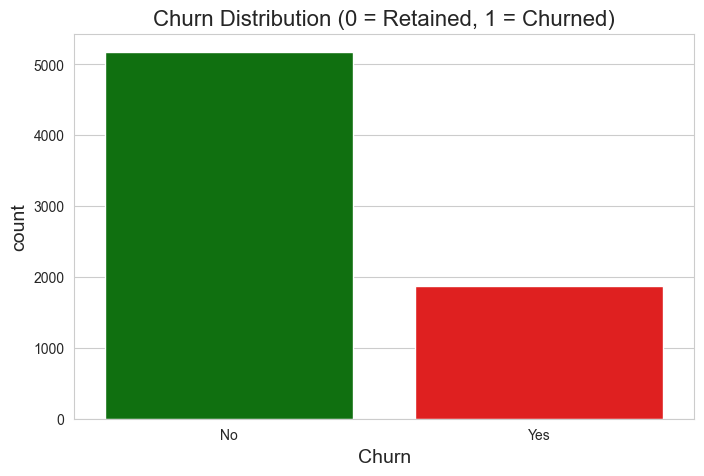

In [5]:
# Target Distribution

plt.figure()
sns.countplot(x="Churn", data=df, palette=["green","red"])
plt.title("Churn Distribution (0 = Retained, 1 = Churned)")
plt.show()


In [6]:
# Percentage table
print(df["Churn"].value_counts(normalize=True).map("{:.2%}".format))

Churn
No     73.46%
Yes    26.54%
Name: proportion, dtype: object


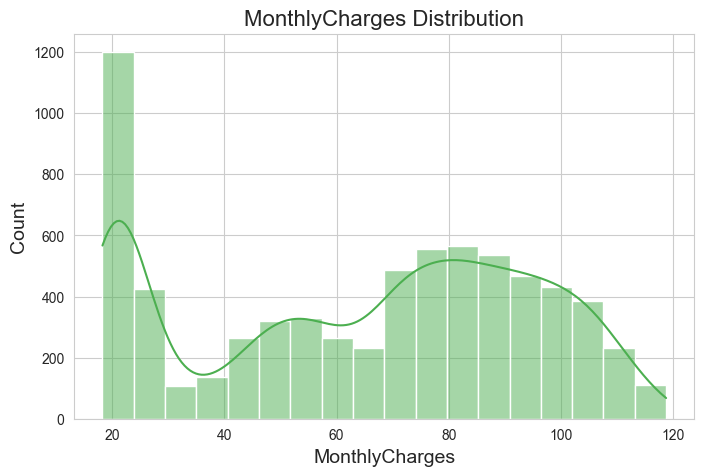

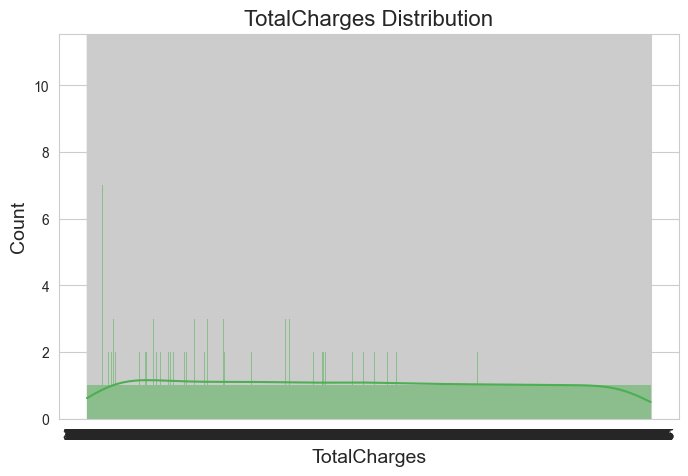

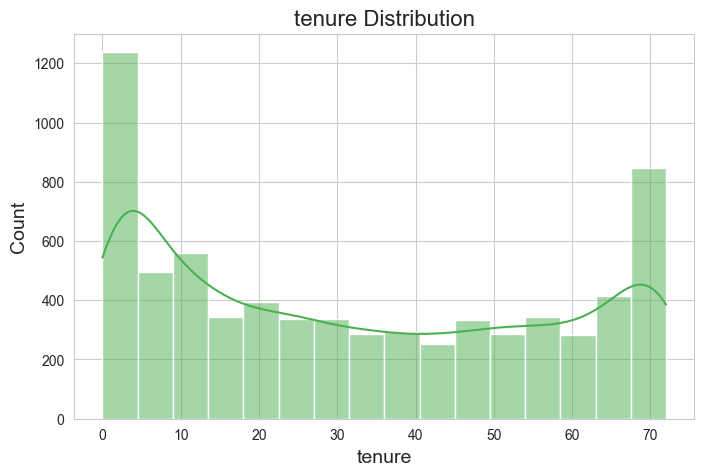

In [7]:
# Numerical Feature Analysis

num_features = ["MonthlyCharges","TotalCharges","tenure"]

for col in num_features:
    plt.figure()
    sns.histplot(df[col], kde=True, color="#4CAF50")
    plt.title(f"{col} Distribution")
    plt.show()

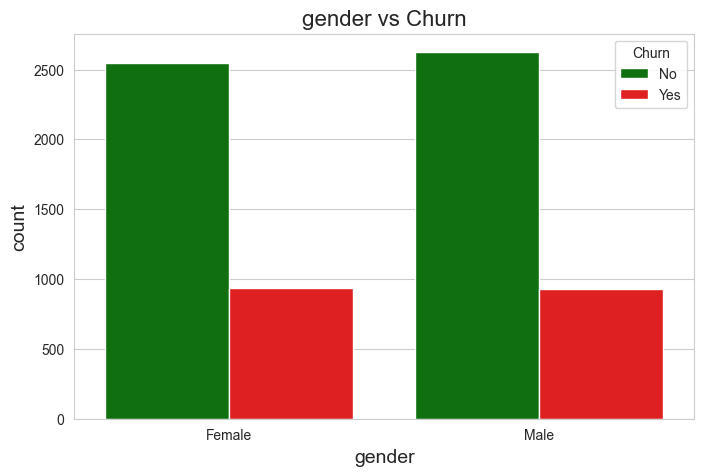

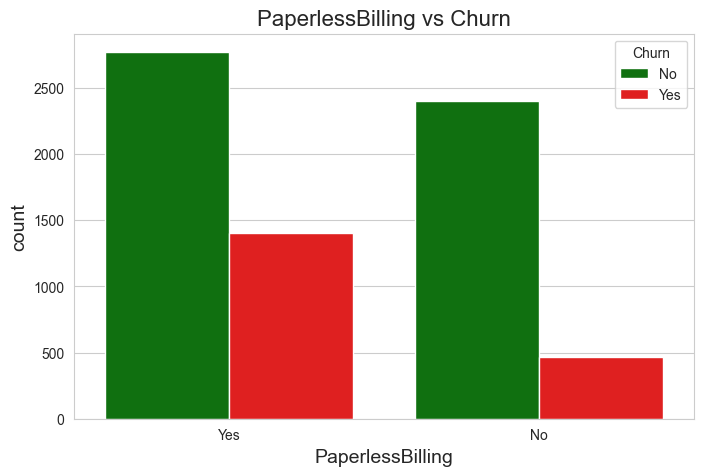

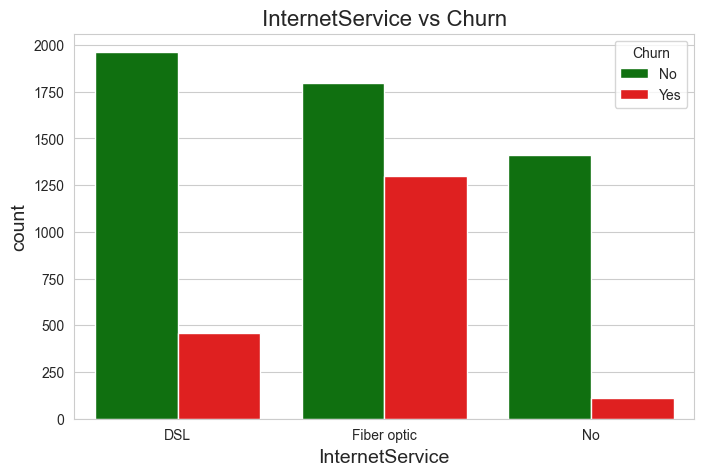

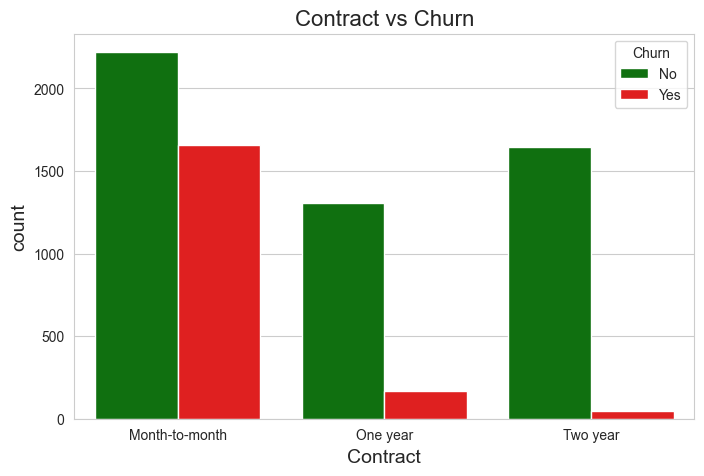

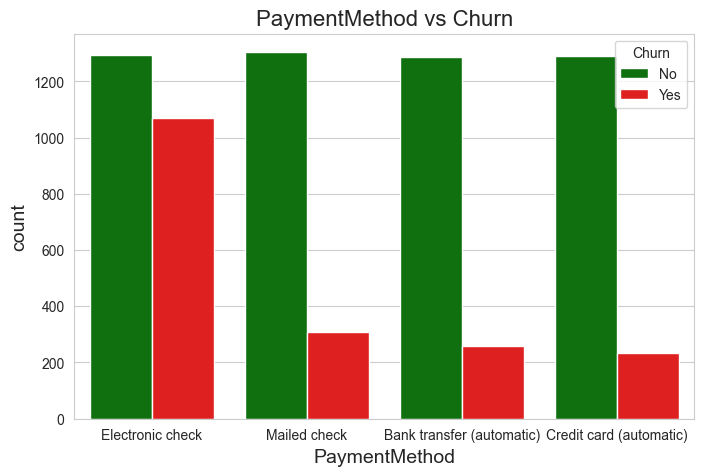

In [8]:
# Categorical Feature Analysis
cat_features = ["gender","PaperlessBilling","InternetService","Contract","PaymentMethod"]

for col in cat_features:
    plt.figure()
    sns.countplot(x=col, hue="Churn", data=df, palette=["green","red"])
    plt.title(f"{col} vs Churn")
    plt.show()

/Users/aryan/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [18:00:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


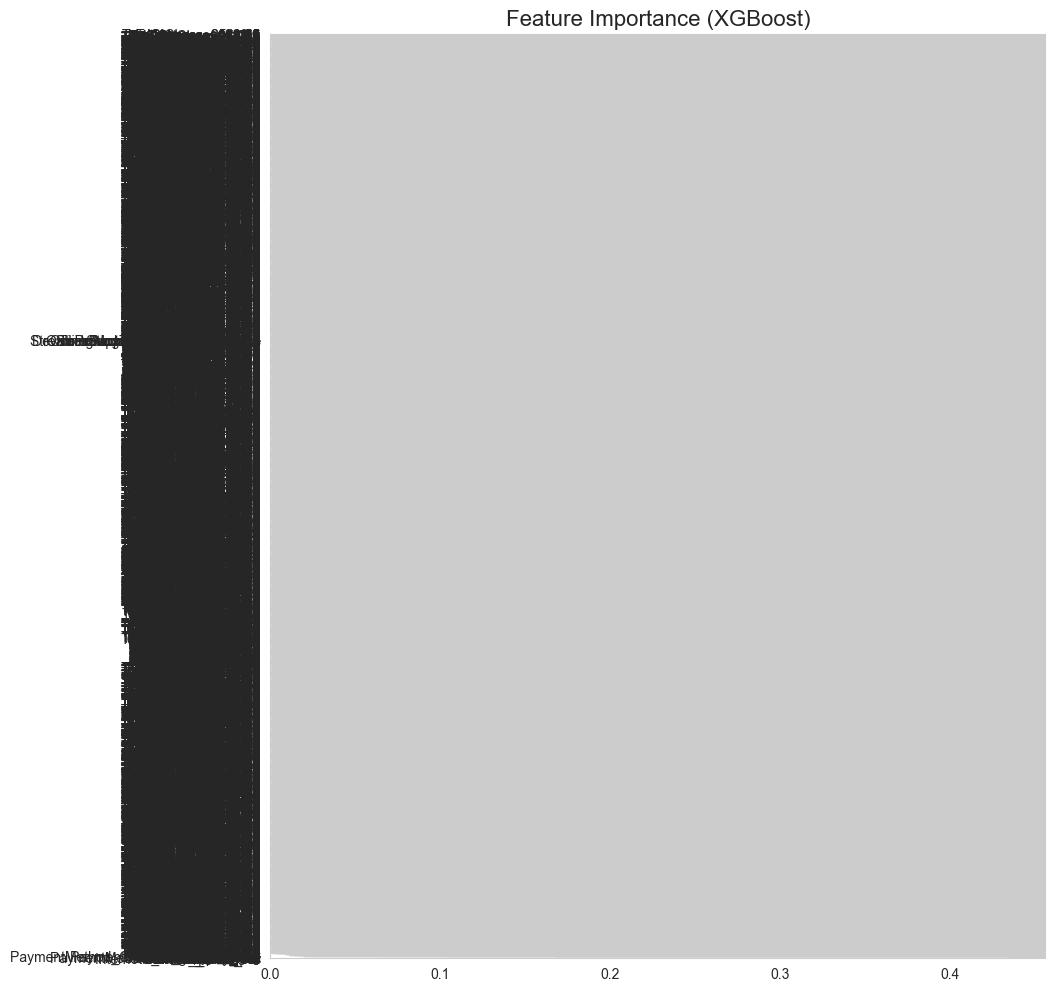

Selected Features: ['SeniorCitizen', 'tenure', 'PhoneService', 'PaperlessBilling', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


In [9]:
# Convert target

df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})
y = df["Churn"]


# Convert some binary categorical columns to 0/1

binary_cols = ["gender", "Partner", "Dependents", "PhoneService", "PaperlessBilling"]
for col in binary_cols:
    df[col] = df[col].map({"No": 0, "Yes": 1, "Male": 1, "Female": 0})


# Drop non-informative columns

X = df.drop(["customerID", "Churn", "MultipleLines"], axis=1)  # MultipleLines for now

# One-hot encode remaining categorical features

categorical_cols = X.select_dtypes(include="object").columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Fit XGBoost to get feature importance

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind="barh", figsize=(10,12), color="#4CAF50")
plt.title("Feature Importance (XGBoost)")
plt.show()

# Select top important features

threshold = 0.01  # Keep features with importance > 1%
important_features = importances[importances > threshold].index.tolist()
X_important = X[important_features]

print("Selected Features:", X_important.columns.tolist())

In [10]:
# 10️⃣ Save Processed Data
# -----------------------------
df.to_csv("../data/processed_churn.csv", index=False)
print("Processed data saved to '../data/processed_churn.csv'")

Processed data saved to '../data/processed_churn.csv'
